# Image Processing API with AWS


In this project, we will focus on building an end-to-end solution for aligning skewed text images, using the infrastructure and services available on AWS (Amazon Web Services). The main goal is to demonstrate the ability to implement and integrate different AWS components to create an automated and scalable system that can handle the challenge of correcting the orientation of texts in images captured at various angles.

## Initial Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import ipytest
from pathlib import Path
import base64
import numpy as np
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt

API_FOLDER = Path("src")

sys.path.append(str(API_FOLDER))

DATA_FILEPATH = API_FOLDER / "test_img.png"

ipytest.autoconfig()

%matplotlib inline

cannot find .env file


# Text Image Alignment

In various contexts, such as the document digitization process or reading texts from images captured at non-ideal angles, we face the challenge of correcting the orientation of skewed texts, also known as the "*deskew*" problem.

The automatic correction of text image tilt not only improves visual readability for humans but also optimizes the performance of OCR (Optical Character Recognition) algorithms, which are more efficient with horizontally aligned texts.

The alignment process, or tilt correction, involves several steps, using image processing techniques. The implemented logic follows a series of steps to identify and correct the image's tilt:

1. **Conversion to Grayscale and Inversion:** First, the image is converted to grayscale to simplify processing by reducing color complexity. Then, the pixels are inverted, so that the text (usually darker) becomes light and the background (usually light) becomes dark.

2. **Thresholding:** A threshold is applied to binarize the image, i.e., pixels can only take two values, black or white. This helps to clearly separate the text from the background, facilitating the identification of the area containing text.

3. **Determination of Image Moment and Tilt Angle:** Using the pixels that represent the text, the image's moment is calculated to find the tilt angle.

4. **Calculation of Correction Angle and Rotation:** Based on the identified tilt angle, the necessary angle to correct the tilt of the image is calculated. The image is then rotated based on this angle to align it correctly.

In this project, we will not go into specific details about the alignment technique itself or the intrinsic aspects of the algorithm used. Instead, we will focus on the architecture and implementation of the solution using the AWS API Gateway, showing how to use services like AWS Lambda, for serverless code execution, and Amazon ECR (Elastic Container Registry), for storing Docker images with OpenCV installed.

In [2]:
def encode_image_to_base64(img: np.ndarray) -> str:
    """
    Encodes an image (NumPy array) directly to a Base64 string representation,
    temporarily saving it to a file.

    Args:
        img (np.ndarray): The image as a NumPy array to be encoded.

    Returns:
        str: The Base64 encoded image representation.
    """
    # Temporary path to save the image
    aux_path = '/tmp/tmp_image.png'
    # Saves the image to the temporary path
    cv2.imwrite(aux_path, img)

    # Opens the saved image, encodes to Base64, and returns the decoded string
    with open(aux_path, "rb") as f:
        encoded_string = base64.b64encode(f.read()).decode("utf-8")

    return encoded_string

In [3]:
encoded_string = encode_image_to_base64(cv2.imread(str(DATA_FILEPATH)))
print(encoded_string[:50])

iVBORw0KGgoAAAANSUhEUgAAAyAAAAKICAIAAAAHKgkIAAAgAE


In [4]:
def decode_base64_to_image(encoded_string: str, img_path: str = "decoded_img.png") -> np.ndarray:
    """
    Decodes a Base64 string to an image and saves it as a file, then reads the image from the file and returns it as a NumPy array.

    Args:
        encoded_string (str): Base64 string of the image to be decoded.
        img_path (str): File path where the decoded image will be saved.

    Returns:
        np.ndarray: The decoded image as a NumPy array.
    """

    img_data = base64.b64decode(encoded_string)
    with open(img_path, "wb") as image_file:
        image_file.write(img_data)

    image = cv2.imread(img_path)
    return image

In [5]:
decoded_im = decode_base64_to_image(encoded_string)
print(decoded_im.shape)

(648, 800, 3)


In [6]:
def deskew_image(image):
    """
    Corrects the skew of the image.

    Parameters:
        image (numpy.ndarray): Image to correct.

    Returns:
        numpy.ndarray: Corrected image.
    """
    # Converts to grayscale and inverts colors
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # Applies threshold to binarize and find coordinates of non-zero pixels
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))

    # Calculates the angle of skew
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Computes the rotation matrix and applies the rotation
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

In [7]:
# deskew image em DATA_FILEPATH
deskewed_im = deskew_image(decoded_im)

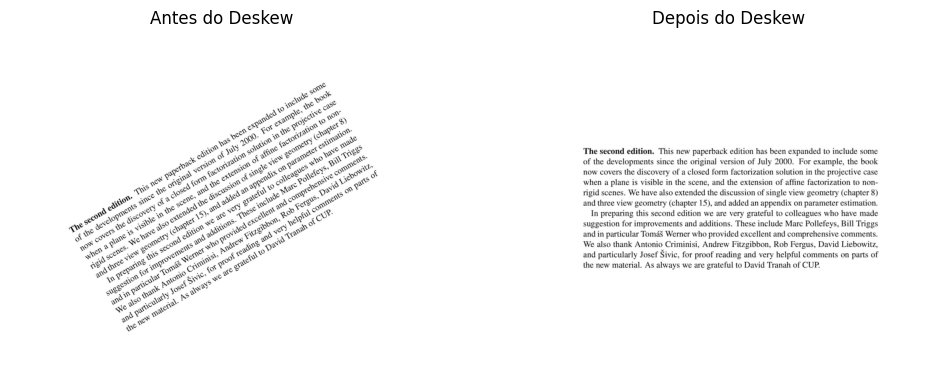

In [17]:
def plot_images(before, after, title_before='Before', title_after='After'):
    """
    Plots two images side by side for comparison.

    Parameters:
        before (numpy.ndarray): Image before processing.
        after (numpy.ndarray): Image after processing.
        title_before (str): Title for the image before processing.
        title_after (str): Title for the image after processing.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax1, ax2 = axes

    ax1.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    ax1.set_title(title_before)
    ax1.axis('off')

    ax2.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    ax2.set_title(title_after)
    ax2.axis('off')

    plt.show()

# Now, using the defined function above to plot images before and after deskew
plot_images(decoded_im, deskewed_im, 'Before Deskew', 'After Deskew')

## Processing Script

In this project, we will not go into specific details about the alignment technique itself or the intrinsic aspects of the utilized algorithm. Instead, our attention will be directed towards the architecture and implementation of the solution on AWS, exploring how services such as Amazon S3 for storage, AWS Lambda for serverless code execution, and Amazon Rekognition for image analysis can be combined to create an efficient image processing pipeline.

By the end of this project, you will have a clear vision of how to design and implement a complete solution on AWS that not only solves a practical image processing problem but also demonstrates the applicability of cloud computing concepts to develop robust and scalable applications. This knowledge will be valuable for a wide range of future applications, establishing a solid foundation for more complex projects involving automated image manipulation and analysis in the cloud.


In [8]:
%%writefile {API_FOLDER}/app.py


import json
import cv2
import base64
import numpy as np

def encode_image_to_base64(
        img: np.ndarray
        ) -> str:
    """
    Codifica uma imagem (array da NumPy) diretamente para a representação em string Base64, 
    salvando temporariamente em um arquivo.

    Args:
        img (np.ndarray): A imagem como um array da NumPy para ser codificada.

    Returns:
        str: A representação da imagem codificada em Base64.
    """
    # Caminho temporário para salvar a imagem
    aux_path = '/tmp/tmp_image.png'
    # Salva a imagem no caminho temporário
    cv2.imwrite(aux_path, img)

    # Abre a imagem salva, codifica em Base64, e retorna a string decodificada
    with open(aux_path, "rb") as f:
        encoded_string = base64.b64encode(f.read()).decode("utf-8")

    return encoded_string


def decode_base64_to_image(
        encoded_string: str,
        img_path: str = "/tmp/decoded_img.png"
        ) -> np.ndarray:
    """
    Decodifica uma string Base64 para uma imagem e salva como arquivo, então lê a imagem do arquivo e retorna como um array da NumPy.

    Args:
        encoded_string (str): String Base64 da imagem a ser decodificada.
        img_path (str): Caminho do arquivo onde a imagem decodificada será salva. Modificado para /tmp/decoded_img.png

    Returns:
        np.ndarray: A imagem decodificada como um array da NumPy.
    """

    img_data = base64.b64decode(encoded_string)
    with open(img_path, "wb") as image_file:
        image_file.write(img_data)

    image = cv2.imread(img_path)
    return image

    

def deskew_image(image):
    """
    Corrige a inclinação da imagem.

    Parâmetros:
        image (numpy.ndarray): Imagem para corrigir.

    Retorna:
        numpy.ndarray: Imagem corrigida.
    """
    # Converte para tons de cinza e inverte as cores
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # Aplica threshold para binarizar e encontrar coordenadas dos pixels não-zero
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))

    # Calcula o ângulo de inclinação
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Computa a matriz de rotação e aplica a rotação
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated


def lambda_handler(event, context):
    # Exemplo de como obter a string base64 da imagem a partir do evento
    base64_string = event['body']

    # Decodifica a string base64 para uma imagem
    image = decode_base64_to_image(base64_string)

    # Aplica a correção de inclinação na imagem
    processed_image = deskew_image(image)

    # Codifica a imagem processada em Base64
    processed_image_base64 = encode_image_to_base64(processed_image)

    # Retorna a imagem processada codificada em Base64
    return {
        'statusCode': 200,
        'isBase64Encoded': True,
        'headers': {'Content-Type': 'image/png'},
        'body': processed_image_base64
    }


Writing src/app.py


In [19]:
%%ipytest -s

import os
import pytest
import numpy as np
import cv2
from app import encode_image_to_base64, decode_base64_to_image

@pytest.fixture
def create_test_image():
    # Cria uma imagem simples para teste
    image_path = "/tmp/test_image.png"
    image = np.zeros((100, 100, 3), dtype=np.uint8)
    cv2.line(image, (0, 0), (99, 99), (255, 0, 0), 5)  # Adiciona uma linha azul diagonal
    cv2.imwrite(image_path, image)
    yield image_path
    # Remove o arquivo após o teste
    os.remove(image_path)

def test_encode_decode_image(create_test_image):
    image_path = create_test_image
    # Lê a imagem criada pela fixture
    original_img = cv2.imread(image_path)
    
    # Codifica a imagem para Base64
    encoded_str = encode_image_to_base64(original_img)
    
    # Verifica se a string codificada não está vazia
    assert encoded_str != "", "A string codificada está vazia"
    
    # Decodifica a string Base64 de volta para uma imagem
    decoded_img_path = "/tmp/decoded_test_image.png"
    decoded_img = decode_base64_to_image(encoded_str, decoded_img_path)
    
    # Compara a imagem original com a imagem decodificada
    assert np.array_equal(original_img, decoded_img), "A imagem decodificada não corresponde à original"


.
1 passed in 0.01s
